### Imports

In [1]:
using DSP
using WAV
using Plots
# using Polynomials

### Get test signal

In [2]:
function pre_emphasize(signal, alpha=0.95)
    filt_function = PolynomialRatio([1.0, -alpha], [1.0])
    return filt(filt_function, signal)
end

pre_emphasize (generic function with 2 methods)

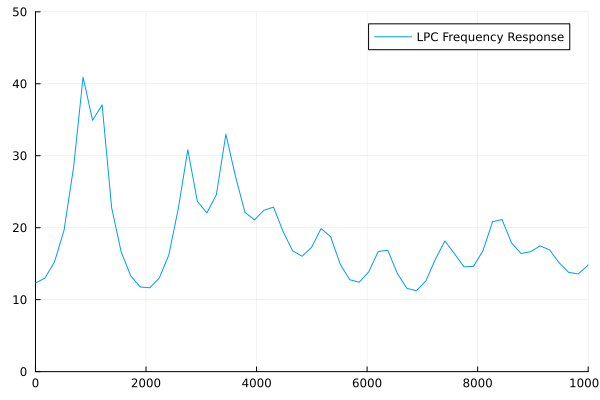

In [3]:
signal, fs, b, opt = wavread("demo_data/aa_audio/audio_lpc_aa_fo160.wav")
signal = signal[1:end]
signal1 = pre_emphasize(signal)
signal2 = pre_emphasize(signal1)
# signal3 = pre_emphasize(signal2)
order = 46
n = 128
a, e = lpc(signal2, order)
a = vcat(1.0, a)
filt_func = PolynomialRatio([1.0], a)
f = [0:(fs/2)/n:fs/2;]
resp = freqz(filt_func, f, fs)
resp = 20*log10.(abs.(resp))
plot(f, resp, xlim=(0,10000), ylim=(0,50), label="LPC Frequency Response")

### Basic peak picking algorithm

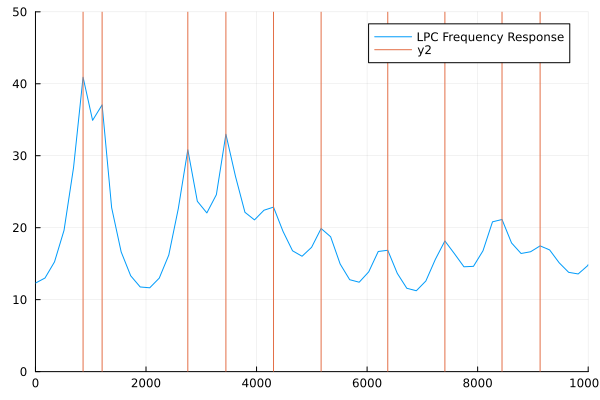

In [4]:
peaks = []
for i in [2:1:length(resp)-1;]
    prev = resp[i-1]
    cur = resp[i]
    next = resp[i+1]
    if cur > prev && cur > next
        push!(peaks, f[i])
    end
end
plot(f, resp, xlim=(0,10000), ylim=(0,50), label="LPC Frequency Response")
vline!(peaks)

### Peak picking algorithm with parabola fitting

In [5]:
# n_points = 5

# peaks = []
# parabolas = []

# for i in [2:1:length(resp)-1;]
#     prev = resp[i-1]
#     cur = resp[i]
#     next = resp[i+1]
#     if cur > prev && cur > next
#         # println(vcat(resp[i-n_points-1:i-1], resp[i+1:i+1+n_points]))
#         quadfit = fit(vcat(f[i-n_points-1:i-1], f[i+1:i+1+n_points]), vcat(resp[i-n_points-1:i-1], resp[i+1:i+1+n_points]), 2)
#         push!(peaks, f[i])
#         push!(parabolas, quadfit)
#     end
# end

# plot(f, resp, xlim=(0,10000), ylim=(0,50), label="LPC Frequency Response")
# scatter!(f, resp, markerstrokewidth=0, markersize=1)
# # vline!(peaks)
# plot!(parabolas[1], f[1], f[end], label="")
# plot!(parabolas[2], f[1], f[end], label="")
# plot!(parabolas[3], f[1], f[end], label="")
# plot!(parabolas[4], f[1], f[end], label="")

# # for parabola in parabolas
# #     plot!(parabola, f[1], f[end], label="")
# # end

In [6]:
function make_parabola(x_points, y_points)
    # make parabola
    A = [x_points[1]^2 x_points[1] 1; x_points[2]^2 x_points[2] 1; x_points[3]^2 x_points[3] 1] 
    y = [y_points[1]; y_points[2]; y_points[3]]
    coeffs = A \ y
    a, b, c = coeffs 
    parabola(x) = a * x^2 + b * x + c

    # calculate delta f
    der_1 = (y_points[3] - y_points[1]) / (2*(x_points[2] - x_points[1]))
    der_2 = (y_points[3] - (2*y_points[2]) + y_points[1]) / ((x_points[2] - x_points[1])^2)
    delta_f = -der_1 / der_2

    return parabola, delta_f
end

make_parabola (generic function with 1 method)

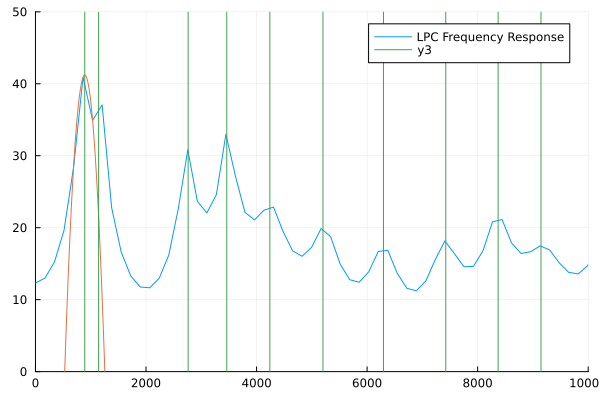

In [7]:
original_peaks = []
interpolated_peaks = []
parabolas = []

for i in [2:1:length(resp)-1;]
    prev = resp[i-1]
    cur = resp[i]
    next = resp[i+1]
    if cur > prev && cur > next
        parabola, delta_f = make_parabola([f[i-1], f[i], f[i+1]], [prev, cur, next])
        x_vals = [f[i-3]:10/500:f[i+3];]
        y_vals = parabola.(x_vals)
        push!(parabolas, (x_vals, y_vals))
        push!(interpolated_peaks, f[i]+delta_f)
    end
end
plot(f, resp, xlim=(0,10000), ylim=(0,50), label="LPC Frequency Response")
plot!(parabolas[1][1], parabolas[1][2], label="")
vline!(interpolated_peaks)

┌ Info: Saved animation to f:\demonstration-notebooks\figures\peak_interpolation.gif
└ @ Plots C:\Users\schno\.julia\packages\Plots\kLeqV\src\animation.jl:156


Plots.AnimatedGif("f:\\demonstration-notebooks\\figures\\peak_interpolation.gif")
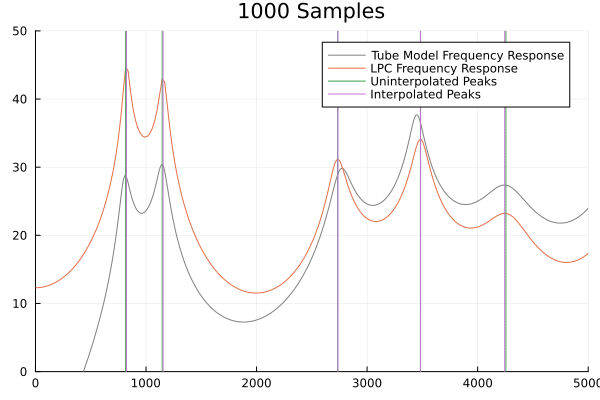

In [8]:
anim = Animation()

for n in [1000:-5:100;]
    # n = 128
    a, e = lpc(signal2, order)
    a = vcat(1.0, a)
    filt_func = PolynomialRatio([1.0], a)
    f = [0:(fs/2)/n:fs/2;]
    resp = freqz(filt_func, f, fs)
    resp = 20*log10.(abs.(resp))
    
    original_peaks = []
    interpolated_peaks = []
    parabolas = []

    # Plot tube model frequency response
    file = open("demo_data/FreqResponse_aa.txt")
    resp1 = []
    resp2 = []
    resp3 = []
    lines = readlines(file)
    for line in lines
        row = split(line, "\t")
        parsed_row = []
        for item in row
            parsed = parse(Float64, item)
            push!(parsed_row, parsed)
        end
        push!(resp1, parsed_row[1])
        push!(resp2, parsed_row[2])
        push!(resp3, parsed_row[3])
    end

    for i in [2:1:length(resp)-1;]
        prev = resp[i-1]
        cur = resp[i]
        next = resp[i+1]
        if cur > prev && cur > next
            parabola, delta_f = make_parabola([f[i-1], f[i], f[i+1]], [prev, cur, next])
            x_vals = [f[i-3]:10/500:f[i+3];]
            y_vals = parabola.(x_vals)
            push!(parabolas, (x_vals, y_vals))
            push!(interpolated_peaks, f[i]+delta_f)
            push!(original_peaks, f[i])
        end
    end
    plot(resp1, resp2, xlim=(0,5000), ylim=(0,50), title="$(n) Samples", color="grey", label="Tube Model Frequency Response")
    plot!(f, resp, label="LPC Frequency Response")
    # plot!(parabolas[1][1], parabolas[1][2], label="")
    vline!(original_peaks, label="Uninterpolated Peaks")
    vline!(interpolated_peaks, label="Interpolated Peaks")
    frame(anim)
end
gif(anim, "figures/peak_interpolation.gif", fps=5)